In [85]:
from dataclasses import dataclass
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path

In [86]:
sns.set_theme(style="whitegrid")

ASSIGNMENT_PATH = Path().resolve().parent
DATA_PATH = ASSIGNMENT_PATH / "data"
OUTPUT_PATH = ASSIGNMENT_PATH / "output"
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)
EXPORT_DPI = 600
assert DATA_PATH.exists()

In [87]:
@dataclass
class ModelParams:
    p: int
    d: int
    q: int
    P: int
    D: int
    Q: int
    s: int

    phis: list[float]
    Phis: list[float]
    thetas: list[float]
    Thetas: list[float]

    var: float

    def to_params(self):
        """
        Convert the model parameters to a list of parameters for the SARIMAX model.
        """
        params = []
        params.extend(self.phis)
        params.extend(self.thetas)
        params.extend(self.Phis)
        params.extend(self.Thetas)
        params.append(self.var)

        assert len(params) == self.p + self.q + self.P + self.Q + 1
        return params

    def to_model(self):
        pdq = (self.p, self.d, self.q)
        seasonal_PDQs = (self.P, self.D, self.Q, self.s)

        return SARIMAX(
            [],
            order=pdq,
            seasonal_order=seasonal_PDQs,
        )

    @classmethod
    def from_weights(
        cls,
        phis: list[float] | None = None,
        thetas: list[float] | None = None,
        Phis: list[float] | None = None,
        Thetas: list[float] | None = None,
        d: int = 0,
        D: int = 0,
        s: int = 0,
        var: float = 1.0,
    ):
        """
        Create a ModelParameters instance from a list of parameters.
        """
        if phis is None:
            phis = []
        if thetas is None:
            thetas = []
        if Phis is None:
            Phis = []
        if Thetas is None:
            Thetas = []

        p = len(phis)
        q = len(thetas)
        P = len(Phis)
        Q = len(Thetas)

        return cls(
            p=p,
            d=d,
            q=q,
            P=P,
            D=D,
            Q=Q,
            s=s,
            phis=phis,
            Phis=Phis,
            thetas=thetas,
            Thetas=Thetas,
            var=var,
        )


def plotter(df, params, *, title, n_lags=30):
    """
    Plot the simulated data from a SARIMAX model using a 2-column layout.

    Parameters:
    - model: SARIMAX model instance
    - params: list of parameters for the model
    - n: number of observations to simulate
    - title: title for the overall figure
    """
    # Create a 2×1+1×2 subplot layout
    fig, axes = plt.subplot_mosaic([["ts", "ts"], ["acf", "pacf"]], figsize=(10, 5))

    param_desc = f"(p, d, q) = ({params.p}, {params.d}, {params.q})"
    param_desc += (
        f"\\quad (P, D, Q)_s = ({params.P}, {params.D}, {params.Q})_{{{params.s}}}"
    )
    weights = []
    weights.extend([f"ϕ_{i + 1} = {params.phis[i]}" for i in range(0, params.p)])
    weights.extend([f"θ_{i + 1} = {params.thetas[i]}" for i in range(0, params.q)])
    weights.extend([f"Φ_{i + 1} = {params.Phis[i]}" for i in range(0, params.P)])
    weights.extend([f"Θ_{i + 1} = {params.Thetas[i]}" for i in range(0, params.Q)])
    weights.append(f"σ^2 = {params.var}")

    param_desc += f"\\quad {', '.join(weights)}"
    param_desc = "$" + param_desc + "$"
    title += "\n" + param_desc
    fig.suptitle(title, fontsize=14)

    # Time series
    sns.lineplot(df, x="t", y="y", ax=axes["ts"])
    # axes["ts"].set_title("Time Series")
    axes["ts"].set_xlabel("Discretised Time, $t$")
    axes["ts"].set_ylabel("Observation, $y_t$")

    # ACF plot
    plot_acf(df["y"], lags=n_lags, ax=axes["acf"], alpha=0.05, auto_ylims=True)
    axes["acf"].set_title("Autocorrelation")
    axes["acf"].set_xlabel("Lag, $k$")
    axes["acf"].set_ylabel("$ρ(k)$")

    # PACF plot
    plot_pacf(
        df["y"], lags=n_lags, ax=axes["pacf"], alpha=0.05, zero=False, auto_ylims=True
    )
    axes["pacf"].set_title("Partial Autocorrelation")
    axes["pacf"].set_xlabel("Lag, $k$")
    axes["pacf"].set_ylabel("$φ(k)$")

    plt.tight_layout()
    plt.subplots_adjust(top=0.87)  # Make room for the title
    return fig, axes


def make_data(params, n=1000, burn_in=1000, rng_seed: int = 0):
    """
    Create a SARIMAX model and simulate data.
    """

    model = params.to_model()
    # print(model.param_names)

    # Simulate data
    t = np.arange(n)
    rng = np.random.default_rng(rng_seed)
    y = model.simulate(params.to_params(), n + burn_in, random_state=rng)[burn_in:]

    return pd.DataFrame({"y": y, "t": t})


def make_and_plot(params, n=1000, title="SARIMAX Model Simulation", n_lags=30):
    """
    Create and plot a SARIMAX model with the given parameters.
    """
    df = make_data(params, n)
    fig, axes = plotter(df, params, title=title, n_lags=n_lags)
    return fig
    # plt.savefig(OUTPUT_DIR / f"1_4_{pdq}_{seasonal_PDQs}.png", dpi=DPI_EXPORT)


## 1.1

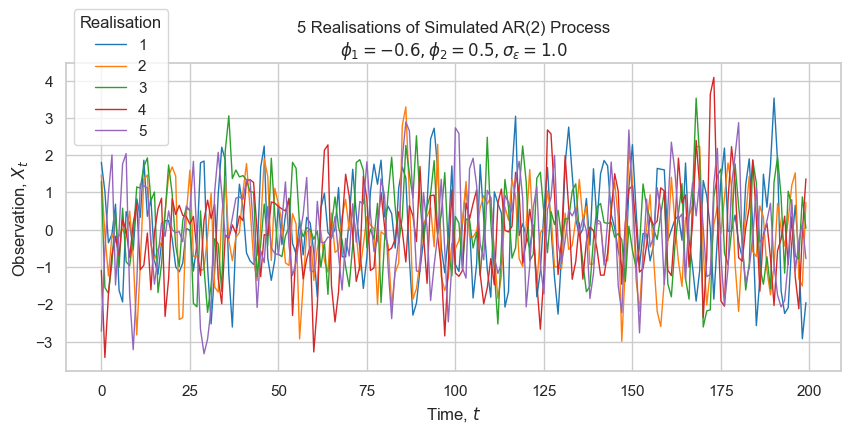

In [88]:
params_1_1 = ModelParams.from_weights(
    phis=[-(-0.6), -(0.5)],  # Note: Sign change
    var=1.0
)

rng = np.random.default_rng(0)
df = pd.DataFrame()

for i in range(5):
    model = params_1_1.to_model()

    # Burn-in period
    BURN_IN = 10000
    n = 200
    t = np.arange(n)
    y = model.simulate(params_1_1.to_params(), n + BURN_IN, random_state=rng)[BURN_IN:]

    df_i = pd.DataFrame({"y": y, "t": t})
    df_i["i"] = i
    df_i["Realisation"] = i + 1
    df = pd.concat([df, df_i], ignore_index=True)

df


fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(
    df, x="t", y="y", hue="Realisation", palette="tab10", lw=1, ax=ax
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(0.0, 1.2))
plt.title("5 Realisations of Simulated AR(2) Process\n$ϕ_1 = -0.6, ϕ_2 = 0.5, σ_ε = 1.0$")
plt.xlabel("Time, $t$")
plt.ylabel("Observation, $X_t$")
plt.savefig(OUTPUT_PATH / "1_1.png", dpi=EXPORT_DPI, bbox_inches="tight")

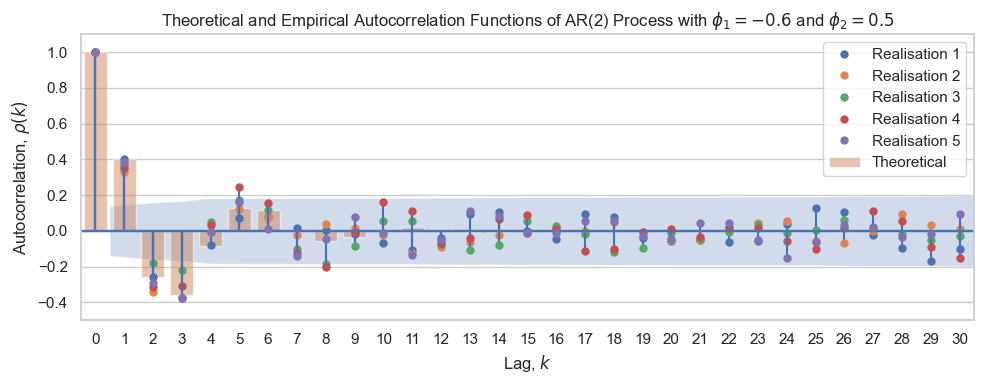

In [89]:
fig, ax1 = plt.subplots(figsize=(10, 4))

# Empirical
N_LAGS = 30
for i, group in df.groupby("i"):
    # ACF plot - adds elements to ax1
    alpha = 0.05 if i == 0 else None
    plot_acf(group["y"], lags=N_LAGS, ax=ax1, alpha=alpha, label=f"Realisation {i + 1}")

# Theoretical
phi_1 = -0.6
phi_2 = 0.5
rhos = [1, -phi_1 / (1 + phi_2)]
for k in range(2, 30 + 1):
    rhos.append(-phi_1 * rhos[k - 1] - phi_2 * rhos[k - 2])
df_rhos = pd.DataFrame(rhos, columns=["rho"])
df_rhos["k"] = df_rhos.index

# Add theoretical bars - adds elements to ax1
# Add the label directly here for easier retrieval later
sns.barplot(df_rhos, x="k", y="rho", alpha=0.5, ax=ax1, label="Theoretical")


# Get all handles and labels currently associated with the axes
handles, labels = ax1.get_legend_handles_labels()

# Filter handles and labels to keep only the ones we want
filtered_handles = []
filtered_labels = []
seen_labels = set() # Keep track of labels to avoid duplicates if necessary

for i, (handle, label) in enumerate(zip(handles, labels)):
    if i % 2 == 1 or label == "Theoretical":
        filtered_handles.append(handle)
        filtered_labels.append(label)

# Create the custom legend using the filtered lists
ax1.legend(handles=filtered_handles, labels=filtered_labels, loc='upper right')


plt.ylim(-0.5, 1.1)
plt.ylabel("Autocorrelation, $ρ(k)$")
plt.xlabel("Lag, $k$")
plt.title("Theoretical and Empirical Autocorrelation Functions of AR(2) Process with $ϕ_1=-0.6$ and $ϕ_2=0.5$")
plt.tight_layout()

plt.savefig(OUTPUT_PATH / "1_2_acf.png", dpi=EXPORT_DPI, bbox_inches="tight")
# ...existing code...

In [90]:
def do_plot(params, id_: str):

    rng = np.random.default_rng(0)
    df = pd.DataFrame()

    for i in range(5):
        model = params.to_model()

        # Burn-in period
        BURN_IN = 10000
        n = 200
        t = np.arange(n)
        y = model.simulate(params.to_params(), n + BURN_IN, random_state=rng)[BURN_IN:]

        df_i = pd.DataFrame({"y": y, "t": t})
        df_i["i"] = i
        df_i["Realisation"] = i + 1
        df = pd.concat([df, df_i], ignore_index=True)

    fig, ax = plt.subplots(figsize=(10, 4))
    sns.lineplot(
        df, x="t", y="y", hue="Realisation", palette="tab10", lw=1, ax=ax
    )
    sns.move_legend(ax, "upper left", bbox_to_anchor=(0.0, 1.2))

    phi_1 = - params.phis[0]
    phi_2 = - params.phis[1]
    plt.title(f"5 Realisations of Simulated AR(2) Process\n$ϕ_1 = {phi_1}, ϕ_2 = {phi_2}, σ_ε = 1.0$")
    plt.xlabel("Time, $t$")
    plt.ylabel("Observation, $X_t$")
    plt.savefig(OUTPUT_PATH / f"{id_}.png", dpi=EXPORT_DPI, bbox_inches="tight")

    ### ACF
    fig, ax1 = plt.subplots(figsize=(10, 4))

    # Empirical
    N_LAGS = 30
    for i, group in df.groupby("i"):
        # ACF plot - adds elements to ax1
        alpha = 0.05 if i == 0 else None
        plot_acf(group["y"], lags=N_LAGS, ax=ax1, alpha=alpha, label=f"Realisation {i + 1}")

    # Theoretical
    rhos = [1, -phi_1 / (1 + phi_2)]
    for k in range(2, 30 + 1):
        rhos.append(-phi_1 * rhos[k - 1] - phi_2 * rhos[k - 2])
    df_rhos = pd.DataFrame(rhos, columns=["rho"])
    df_rhos["k"] = df_rhos.index

    # Add theoretical bars - adds elements to ax1
    # Add the label directly here for easier retrieval later
    sns.barplot(df_rhos, x="k", y="rho", alpha=0.5, ax=ax1, label="Theoretical")


    # Get all handles and labels currently associated with the axes
    handles, labels = ax1.get_legend_handles_labels()

    # Filter handles and labels to keep only the ones we want
    filtered_handles = []
    filtered_labels = []

    for i, (handle, label) in enumerate(zip(handles, labels)):
        if i % 2 == 1 or label == "Theoretical":
            filtered_handles.append(handle)
            filtered_labels.append(label)

    # Create the custom legend using the filtered lists
    ax1.legend(handles=filtered_handles, labels=filtered_labels, loc='upper right')


    plt.ylim(-0.5, 1.1)
    plt.ylabel("Autocorrelation, $ρ(k)$")
    plt.xlabel("Lag, $k$")
    plt.title(f"Theoretical and Empirical Autocorrelation Functions of AR(2) Process with $ϕ_1 = {phi_1}, ϕ_2 = {phi_2}$")
    plt.tight_layout()

    plt.savefig(OUTPUT_PATH / f"{id_}_acf.png", dpi=EXPORT_DPI, bbox_inches="tight")



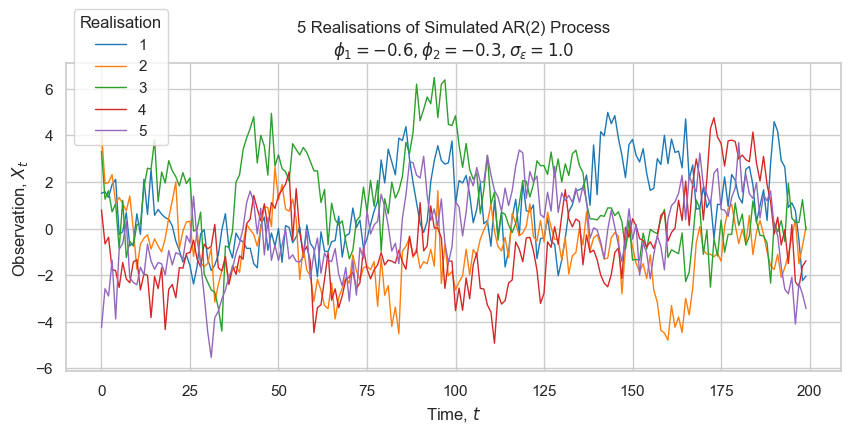

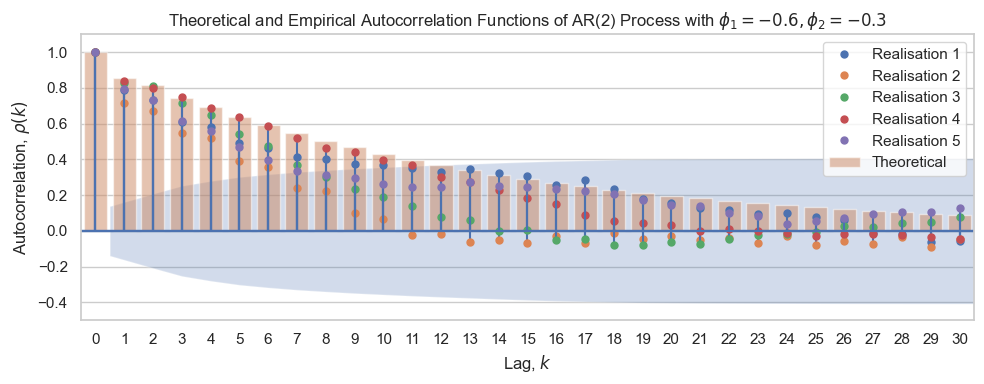

In [91]:
# 1.3
params = ModelParams.from_weights(
    phis=[-(-0.6), -(-0.3)],  # Note: Sign change
    var=1.0
)

do_plot(params, "1_3")

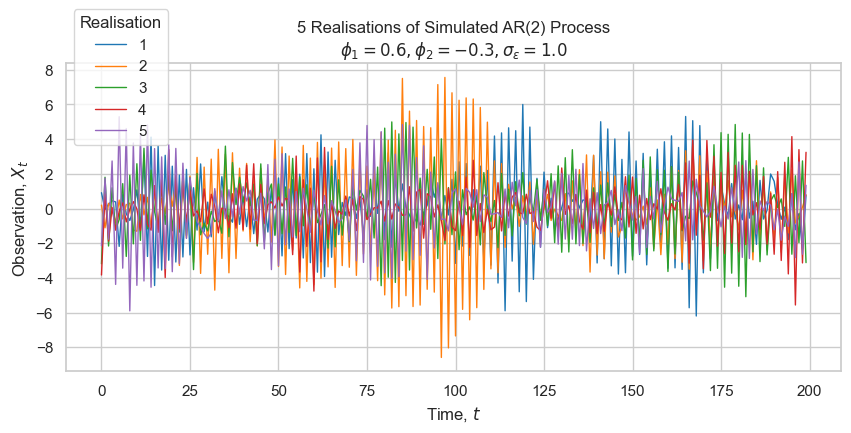

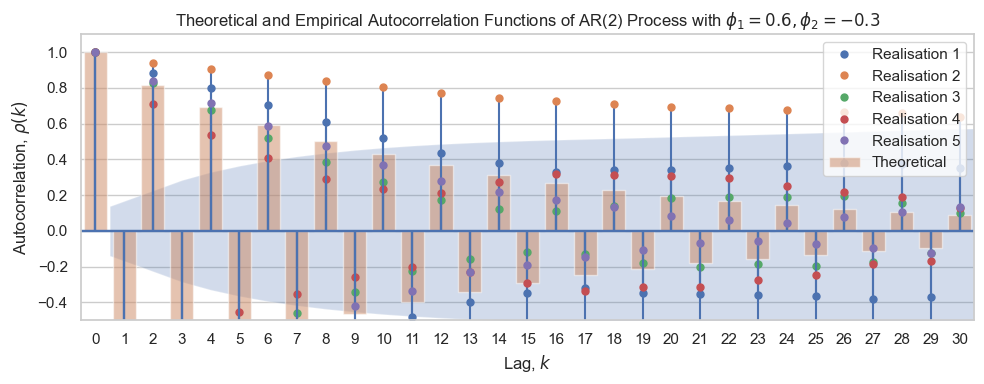

In [92]:
# 1.4
params = ModelParams.from_weights(
    phis=[-(0.6), -(-0.3)],  # Note: Sign change
    var=1.0
)

do_plot(params, "1_4")

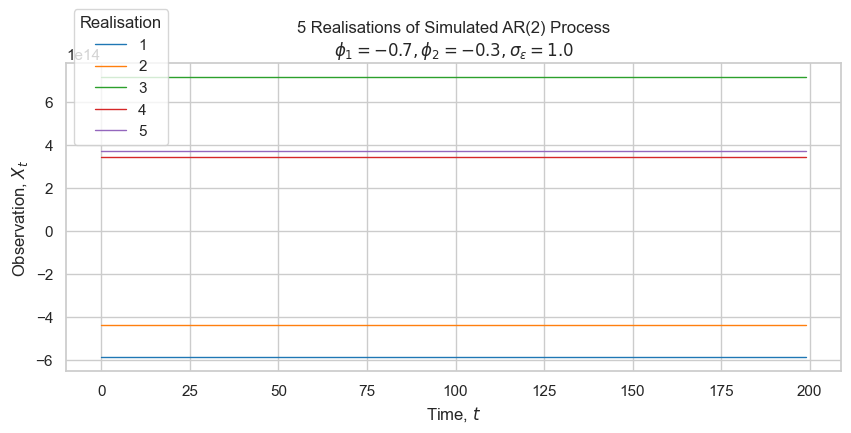

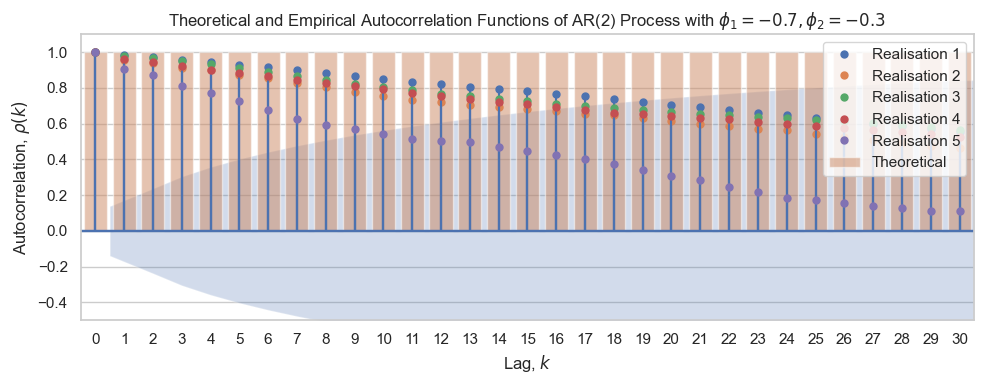

In [93]:
# 1.5
params = ModelParams.from_weights(
    phis=[-(-0.7), -(-0.3)],  # Note: Sign change
    var=1.0
)
do_plot(params, "1_5")

c:\Users\jeppe\Documents\MEGA\Base\DTU\02417 Time Series Analysis\Assignments\.venv\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


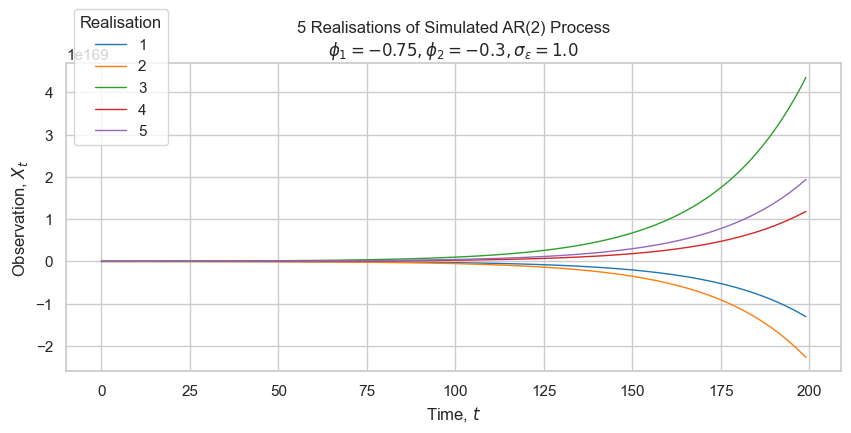

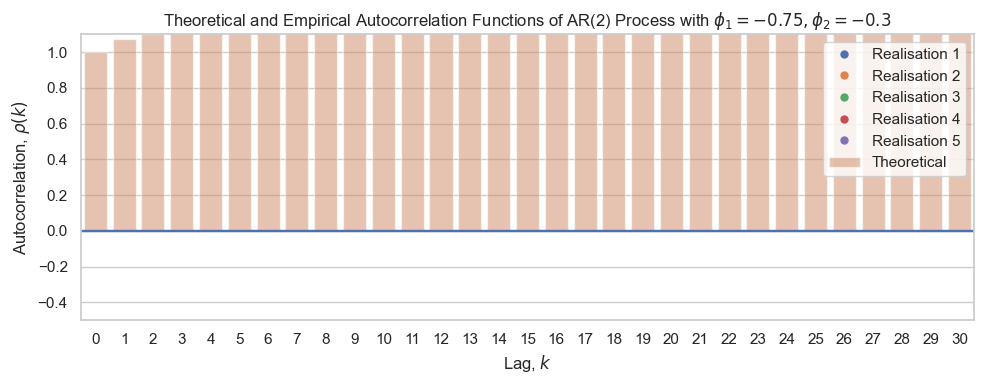

In [94]:
# 1.6
params = ModelParams.from_weights(
    phis=[-(-0.75), -(-0.3)],  # Note: Sign change
    var=1.0
)
do_plot(params, "1_6")

## 1.4

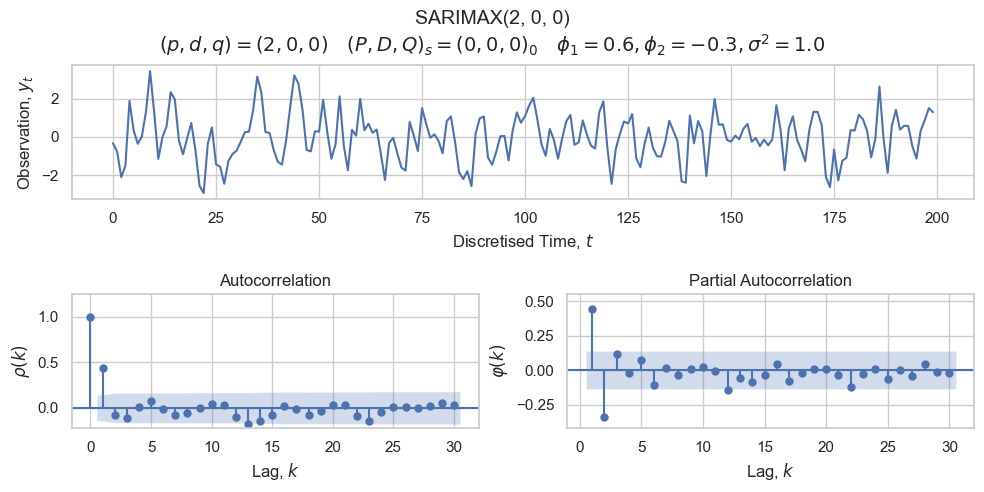

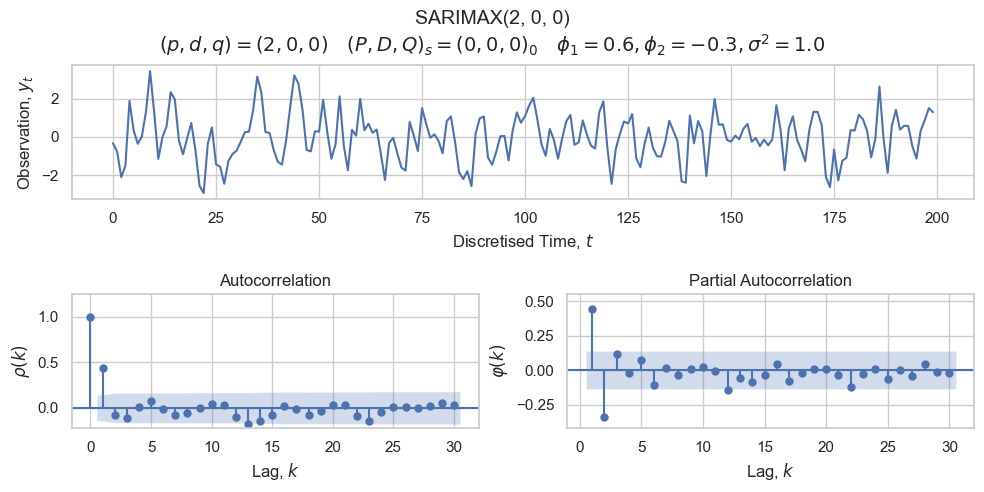

In [95]:
params_1_4 = ModelParams.from_weights(
    phis=[0.6, -0.3],
)
make_and_plot(params_1_4, n=200, title="SARIMAX(2, 0, 0)")